In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

import pandas as pd
import matplotlib.pyplot as plt

# Projeto de Engenharia de Dados
## Criando um pipeline de dados relacionados a suicídios cometidos no Brasil entre 2010 e 2019

O suicídio é um problema grave de saúde pública que afeta milhões de pessoas em todo o mundo. No Brasil, como em muitos outros países, a Classificação Internacional de Doenças (CID) é utilizada para registrar e categorizar as causas de morte, incluindo suicídios. A CID-10, em particular, dedica uma seção específica às causas externas de morbidade e mortalidade, onde os suicídios são classificados sob os códigos X600 a X850. Esses códigos são essenciais para identificar e monitorar os casos de suicídio, permitindo que os profissionais de saúde e pesquisadores analisem tendências e desenvolvam estratégias de prevenção.

Através da CID-10, é possível identificar que uma pessoa cometeu suicídio ao verificar se o código de causa de morte está dentro do grupo X600-X850, que inclui lesões autoprovocadas intencionalmente, como suicídio e tentativas de suicídio. Essa informação é crucial para a vigilância epidemiológica e para a implementação de políticas públicas eficazes na prevenção do suicídio.

Ao correlacionar dados de suicídio com a CID-10 é possível realizar uma análise mais aprofundada dos padrões e tendências de suicídio, ajudando a melhorar a compreensão e a resposta a esse problema de saúde pública.

## Objetivo

Este projeto visa desenvolver um pipeline de dados capaz de realizar a extração, transformação e carga (ETL) dos dados disponíveis sobre suicídio correlacionando-os com a Classificação Internacional de Doenças (CID-10). Ao final do pipeline, teremos a disposição um dataset com dados tratados que possibilitarão iniciar uma análise para geração de insights sobre este grave problema de saúde pública.

O problema central a ser abordado é a dificuldade na identificação e análise precisa dos dados de suicídio, que são frequentemente registrados sob códigos específicos da CID-10 (X600 a X850). Esses códigos são cruciais para monitorar e entender as tendências de suicídio.

As principais perguntas de negócio que este trabalho visa responder incluem:

1. Qual o ano com a maior quantidade de registros de suicídio?
2. Para cada ano, qual o estado brasileiro com o maior número de suicídios?
3. Para cada estado brasileiro, quais os municípios que concentraram a maior parte dos indivíduos que cometeram suicídio (seus municípios de residência)?
4. Quem mais cometeu suicídios: homens ou mulheres?
5. Qual a taxa de suicídios entre as pessoas com diferentes níveis de escolaridade?
6. Quais as TOP 5 ocupações das pessoas que cometeram suicídio?
7. Quais as idades mínima e máxima das pessoas que cometeram suicídio?
8. Qual a raça/cor das pessoas que mais cometeram suicídio?
9. Quais os locais onde mais se cometeram suicídios?
10. Qual o período do ano em que as pessoas mais cometeram suicídio? É um comportamento que se repete em todos os anos?
11. Quais são as TOP 5 causas mais frequentes de suicídios?
12. Para cada ano, quais as TOP 3 causas mais frequentes de suicídios? Há um padrão de comportamento ao longo dos anos?

Ao responder a essas perguntas, este projeto busca contribuir para a melhoria da compreensão dos casos de suicídio que ocorreram no Brasil entre 2010 a 2019.

## Linhagem dos Dados
O DATASUS disponibiliza publicamente dados relacionados a suicídios cometidos no Brasil. Estes podem ser encontrados em:
-  https://opendatasus.saude.gov.br/dataset/sim  

Com base nestas informações, foi disponibilizado no Kaggle, um novo dataset contendo a série histórica dos suicídios cometidos no Brasil entre os anos de 2010 e 2019.
- https://www.kaggle.com/datasets/psicodata/dados-de-suicidios-entre-2010-e-2019

Importante mencionar que os dados de suicídio disponibilizados no Kaggle **não possuem dados nulos**: já houve a **tratativa dos dados faltantes**. Foi realizada a **substituição dos valores nulos pelo valor 'NA'**.

Este dataset faz referência ao CID, informando em 2 de suas colunas o respectivo código. Como abordado anteriormente, o CID se refere a um Diagnóstico que, para este cenárop, foi utilizado para definir a causa do óbito do indivíduo. 

Porém, para fins de análise, a disponibilização somente do código CID não é suficiente para compreensão dos resultados encontrados e respectivas tomadas de decisão. Se faz necessária a descrição do Diagnóstico e, esta informação pode ser encontrada na seguinte referência:
- http://www2.datasus.gov.br/cid10/V2008/cid10.htm

Para este presente trabalho serão utilizados os seguintes datasets:

- dados de suicídio entre 2010 e 2019
  - https://www.kaggle.com/datasets/psicodata/dados-de-suicidios-entre-2010-e-2019
    - suicidios_2010_a_2019.csv
- dados do CID
  - http://www2.datasus.gov.br/cid10/V2008/cid10.htm
    - http://www2.datasus.gov.br/cid10/V2008/downloads/CID10CSV.zip
      - CID-10-SUBCATEGORIAS.CSV

## Catálogo de Dados

### Entidade 'Ocorrência' 

| Nome da Coluna | Tipo    | Descrição                                             | Domínio                                                                 |
|----------------|---------|-------------------------------------------------------|-------------------------------------------------------------------------|
| `#`        | Inteiro | Identificação do registro (número sequencial)         | Valor mínimo: 1 Valor máximo: 112.491                                  |
| `estado`         | Texto   | Estado brasileiro de registro do suicídio            | RJ, SP, MG e demais siglas dos estados                                 |
| `ano`            | Inteiro | Ano de registro do suicídio                          | Valor mínimo: 2010 Valor máximo: 2019                                  |
| `mes`            | Inteiro | Mês de registro do suicídio                          | Valor mínimo: 1 Valor máximo: 12                                       |
| `DTOBITO`        | Data    | Data do óbito no formato YYYY-MM-DD                 | Valor mínimo: 2010-01-01 Valor máximo: 2019-12-31                       |
| `DTNASC`         | Data    | Data de nascimento no formato YYYY-MM-DD            |                                                                         |
| `sexo`           | Texto   | Sexo registrado                                       | Feminino, Masculino, NA                                                |
| `RACACOR`        | Texto   | Raça ou cor de acordo com a classificação do IBGE    | Amarela, Branca, Parda, Preta, Indígena, NA                            |
| `ASSISTMED`      | Texto   | Recebeu assistência médica?                          | Sim, Não, NA                                                            |
| `escmae`         | Texto   | Escolaridade registrada da mãe                       | '1 a 3 anos', '4 a 7 anos', '8 a 11 anos', '12 e mais', 'Nenhuma', 'NA' |
| `ESTCIV`         | Texto   | Estado civil                                          | Casado/a, Solteiro/a, 'União consensual', NA, 'Separado/a judicialmente', Viuvo/a |
| `esc`            | Texto   | Escolaridade (em anos)                               | '1 a 3 anos', '4 a 7 anos', '8 a 11 anos', '12 e mais', 'Nenhuma', 'NA' |
| `OCUP`           | Texto   | Ocupação (profissão)                                 | APOSENTADO/PENSIONISTA, ESTUDANTE, 'DONA DE CASA', dentre outros.      |
| `CODMUNRES`      | Texto   | Município de residência                              | 'São Paulo', 'Porto Velho', 'Fortaleza', 'São Simão', 'Sobral', 'Sorocaba', 'Rio de Janeiro', 'São Gonçalo', dentre outros |
| `CAUSABAS`       | Texto   | Causa básica da declaração de óbito (de acordo com CID) | X600, X700, X705, X850, dentre outros                                |
| `CAUSABAS_O`     | Texto   | Causa básica da morte (de acordo com CID)            | X600, X700, X705, X850, dentre outros                                   |
| `LOCOCOR`        | Texto   | Local de ocorrência da morte                         | Hospital, Domicílio, Outros, 'Via pública', 'Outro estabelecimento de saúde', NA |
| `CIRURGIA`       | Texto   | Indica se foi realizada cirurgia                     | Sim, Não, NA                                                            |


### Entidade 'Diagnóstico' 

| Nome da Coluna      | Tipo      | Descrição | Domínio |
|---------------------|-----------|-----------|------------------|
| `SUBCAT` | Texto   | Código CID   | A000, X600, X700, X705, X850, W800        |
| `CLASSIF` | Texto   | Indica a categoria do CID   | em branco: não tem dupla classificação; </br> +: classificação por etiologia; </br> *: classificação por manifestação.        |
| `RESTRSEXO` | Texto   |  Indica se o CID só pode ser usado para homens ou mulheres   | em branco: pode ser utilizada em qualquer situação; </br> F: só deve ser utilizada para o sexo feminino; </br> M: só deve ser utilizada para o sexo masculino.        |
| `CAUSAOBITO` | Texto   |  Indica se o CID pode causar óbito   | em branco: não há restrição; </br> N: a subcategoria tem pouca probabilidade de causar óbito.         |
| `DESCRICAO` | Texto   | Descrição do CID   | 'Febre tifóide',  'Cólera não especificada',  'Botulismo', 'Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - residência', dentre outros     |
| `DESCRABREV` | Texto   | Descrição abreviada do CID   | 'A01.0 Febre tifoide', 'A00.9 Colera NE', 'A05.1 Botulismo', 'X70.0 Residencia', dentre outros    |
| `REFER` | Texto   | Referencia outro código CID, quando aplicável   | 'B02.2+, 'A18.8+', 'A23.-+', dentre outros        |
| `EXCLUIDOS` | Texto   | Indica códigos excluídos que agora se referem ao respectivo CID   | N975, Q352, S446, dentre outros   |

## Modelagem de Dados

Para este trabalho optou-se pela criação de uma tabela flat, como adotado em um Data Lake.

Ao longo do pipeline descrito a seguir, será realizada a junção das 2 entidades descritas na seção acima para dar origem a entidade **OCORRENCIAS_SUICIDIOS**.

A junção entre as entidades ocorre utilizando as seguintes informações:
- **OCORRENCIA.CD_CID**
    - nova coluna que será criada ao longo do pipeline a ser descrito a seguir
    - esta nova coluna deverá receber valores de código CID que variam entre X600 e X850, visto que esta é a regra de negócio que indica que tal registro se trata de um suicídio
    - tal valor de código CID é obtido através das colunas OCORRENCIA.CAUSABAS ou OCORRENCIA.CAUSABAS_O
        - uma destas duas colunas possui o código CID que obedece esta regra
        - o valor selecionado será carregado na nova coluna OCORRENCIA.CD_CID 

- **DIAGNOSTICO.SUBCAT**

A seguir é apresentado o modelo de dados da tabela flat que será utilizada para responder as perguntas de negócio:

![](https://github.com/andressapedrosa/data_engineering/blob/43911f3d8ea23f43911623412bebdfd39478b377/modelo_ocorrencias_suicidios.jpg?raw=true)

## Busca dos Dados

In [0]:
# Criação de uma SparkSession
spark = SparkSession.builder.appName("Leitura CSV com PySpark").getOrCreate()

# Leitura de arquivos CSVs e criação de DataFrames

# Conjunto de Dados principal: contem registros dos suicidios
df_suicidios = spark.read.csv('dbfs:/FileStore/suicidios_2010_a_2019.csv', header=True, inferSchema=True)

# Conjunto de Dados auxiliar: contem informações do CID (Código Internacional de Doenças)
df_cids = spark.read.csv('dbfs:/FileStore/CID_10_SUBCATEGORIAS.CSV', sep=';', encoding="Windows-1252", header=True, inferSchema=True)

In [0]:
# Exibição dos primeiros registros do DataFrame
df_suicidios.limit(5).display()

_c0,estado,ano,mes,DTOBITO,DTNASC,SEXO,RACACOR,ASSISTMED,ESCMAE,ESTCIV,ESC,OCUP,CODMUNRES,CAUSABAS,CAUSABAS_O,LOCOCOR,CIRURGIA
1,AC,2010,1,2010-01-31,1999-11-09,Masculino,Parda,NA,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,X780,X780,Via pública,Não
2,AC,2010,2,2010-02-07,1985-09-23,Masculino,Parda,NA,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,X780,X780,Hospital,Não
3,AC,2010,2,2010-02-19,1995-08-06,Masculino,Parda,NA,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,X780,X780,Hospital,Não
4,AC,2010,4,2010-04-20,1983-12-25,Feminino,Parda,NA,NA,Casado/a,1 a 3 anos,DONA DE CASA,Tarauacá,X780,X780,Domicílio,Não
5,AC,2010,7,2010-07-24,1982-05-13,Masculino,Parda,NA,NA,Casado/a,NA,DONA DE CASA,Tarauacá,X720,X720,Domicílio,Não


In [0]:
# Exibição dos primeiros registros do DataFrame
df_cids.limit(5).display()

SUBCAT,CLASSIF,RESTRSEXO,CAUSAOBITO,DESCRICAO,DESCRABREV,REFER,EXCLUIDOS,_c8
A000,null,null,null,"Cólera devida a Vibrio cholerae 01, biótipo cholerae",A00.0 Colera dev Vibrio cholerae 01 biot cholerae,null,null,null
A001,null,null,null,"Cólera devida a Vibrio cholerae 01, biótipo El Tor",A00.1 Colera dev Vibrio cholerae 01 biot El Tor,null,null,null
A009,null,null,null,Cólera não especificada,A00.9 Colera NE,null,null,null
A010,null,null,null,Febre tifóide,A01.0 Febre tifoide,null,null,null
A011,null,null,null,Febre paratifóide A,A01.1 Febre paratifoide A,null,null,null


## Carga dos dados

Nesta sessão serão criadas 3 camadas de dados, sendo elas:

- _suicidios_br_bronze_
    - apresenta os dados no formato 'raw': são cópias idênticas das informações capturadas nas respectivas origens
- _suicidios_br_silver_
    - apresenta os dados tratados e refinados
- _suicidios_br_gold_
    - apresenta os dados curados: modelados para atender às necessidades de negócio

In [0]:
%sql
-- Criando a instância de banco de dados
DROP DATABASE suicidios_br_bronze CASCADE;
CREATE DATABASE suicidios_br_bronze;

DROP DATABASE suicidios_br_silver CASCADE;
CREATE DATABASE suicidios_br_silver;

DROP DATABASE suicidios_br_gold CASCADE;
CREATE DATABASE suicidios_br_gold;

###Carregando dados na camada bronze (raw)

In [0]:
%sql
USE DATABASE suicidios_br_bronze;

In [0]:
# Salvando o DataFrame como uma tabela
df_suicidios.write.mode("overwrite").saveAsTable("ocorrencias")
df_cids.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("diagnosticos")

In [0]:
%sql
SELECT * FROM ocorrencias LIMIT 10;

_c0,estado,ano,mes,DTOBITO,DTNASC,SEXO,RACACOR,ASSISTMED,ESCMAE,ESTCIV,ESC,OCUP,CODMUNRES,CAUSABAS,CAUSABAS_O,LOCOCOR,CIRURGIA
1,AC,2010,1,2010-01-31,1999-11-09,Masculino,Parda,NA,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,X780,X780,Via pública,Não
2,AC,2010,2,2010-02-07,1985-09-23,Masculino,Parda,NA,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,X780,X780,Hospital,Não
3,AC,2010,2,2010-02-19,1995-08-06,Masculino,Parda,NA,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,X780,X780,Hospital,Não
4,AC,2010,4,2010-04-20,1983-12-25,Feminino,Parda,NA,NA,Casado/a,1 a 3 anos,DONA DE CASA,Tarauacá,X780,X780,Domicílio,Não
5,AC,2010,7,2010-07-24,1982-05-13,Masculino,Parda,NA,NA,Casado/a,NA,DONA DE CASA,Tarauacá,X720,X720,Domicílio,Não
6,AC,2010,4,2010-04-30,1967-07-13,Feminino,Preta,NA,NA,Solteiro/a,4 a 7 anos,DONA DE CASA,Tarauacá,X780,X780,Hospital,Não
7,AC,2010,1,2010-01-15,1979-09-05,Masculino,Parda,NA,NA,Solteiro/a,4 a 7 anos,NA,Rio Branco,X700,X700,Domicílio,Não
8,AC,2010,1,2010-01-16,1994-01-19,Masculino,Parda,NA,NA,Solteiro/a,NA,NA,Rio Branco,X700,X700,Domicílio,Não
9,AC,2010,9,2010-09-15,1952-04-14,Masculino,Parda,NA,NA,Solteiro/a,NA,NA,Rio Branco,X629,R99,Domicílio,NA
10,AC,2010,9,2010-09-03,1968-08-14,Masculino,Parda,NA,NA,Solteiro/a,NA,NA,Epitaciolândia,X747,X747,Domicílio,Não


In [0]:
%sql
SELECT * FROM diagnosticos LIMIT 10

SUBCAT,CLASSIF,RESTRSEXO,CAUSAOBITO,DESCRICAO,DESCRABREV,REFER,EXCLUIDOS,_c8
A000,null,null,null,"Cólera devida a Vibrio cholerae 01, biótipo cholerae",A00.0 Colera dev Vibrio cholerae 01 biot cholerae,null,null,null
A001,null,null,null,"Cólera devida a Vibrio cholerae 01, biótipo El Tor",A00.1 Colera dev Vibrio cholerae 01 biot El Tor,null,null,null
A009,null,null,null,Cólera não especificada,A00.9 Colera NE,null,null,null
A010,null,null,null,Febre tifóide,A01.0 Febre tifoide,null,null,null
A011,null,null,null,Febre paratifóide A,A01.1 Febre paratifoide A,null,null,null
A012,null,null,null,Febre paratifóide B,A01.2 Febre paratifoide B,null,null,null
A013,null,null,null,Febre paratifóide C,A01.3 Febre paratifoide C,null,null,null
A014,null,null,null,Febre paratifóide não especificada,A01.4 Febre paratifoide NE,null,null,null
A020,null,null,null,Enterite por salmonela,A02.0 Enterite p/salmonela,null,null,null
A021,null,null,null,Septicemia por salmonela,A02.1 Septicemia p/salmonela,null,null,null


###Data Quality

Nesta seção realizaremos uma análise da qualidade dos dados a fim de identificar potenciais problemas nos conjuntos de dados.

Caso sejam encontrados problemas, serão apresentados os tratamentos necessários antes da respectiva carga na camada silver.

#### Análise de dados nulos/faltantes

In [0]:
%sql
SELECT 
  COUNT(*) AS total_linhas,
  COUNT(CASE WHEN (_c0 IS NULL or _c0 = 'NA') THEN 1 END) AS c0_nulos,
  COUNT(CASE WHEN (estado IS NULL or estado = 'NA') THEN 1 END) AS estado_nulos,
  COUNT(CASE WHEN (ano IS NULL or ano = 'NA') THEN 1 END) AS ano_nulos,
  COUNT(CASE WHEN (mes IS NULL or mes = 'NA') THEN 1 END) AS mes_nulos,
  COUNT(CASE WHEN (dtobito IS NULL or dtobito = 'NA') THEN 1 END) AS dt_obito_nulos,
  COUNT(CASE WHEN (dtnasc IS NULL or dtnasc = 'NA') THEN 1 END) AS dt_nasc_nulos,
  COUNT(CASE WHEN (sexo IS NULL or sexo = 'NA') THEN 1 END) AS sexo_nulos,
  COUNT(CASE WHEN (racacor IS NULL or racacor = 'NA')THEN 1 END) AS racacor_nulos,
  COUNT(CASE WHEN (assistmed IS NULL or assistmed = 'NA') THEN 1 END) AS assistmed_nulos,
  COUNT(CASE WHEN (escmae IS NULL or escmae = 'NA') THEN 1 END) AS escmae_nulos,
  COUNT(CASE WHEN (estciv IS NULL or estciv = 'NA') THEN 1 END) AS estciv_nulos,
  COUNT(CASE WHEN (esc IS NULL or esc = 'NA') THEN 1 END) AS esc_nulos,
  COUNT(CASE WHEN (ocup IS NULL or ocup = 'NA') THEN 1 END) AS ocup_nulos,
  COUNT(CASE WHEN (codmunres IS NULL or codmunres = 'NA') THEN 1 END) AS codmunres_nulos,
  COUNT(CASE WHEN (causabas IS NULL or causabas = 'NA') THEN 1 END) AS causabas_nulos,
  COUNT(CASE WHEN (causabas_o IS NULL or causabas_o = 'NA') THEN 1 END) AS causabas_o_nulos,
  COUNT(CASE WHEN (lococor IS NULL or lococor = 'NA') THEN 1 END) AS lococor_nulos,
  COUNT(CASE WHEN (cirurgia IS NULL or cirurgia = 'NA') THEN 1 END) AS cirurgia_nulos
FROM 
  suicidios_br_bronze.ocorrencias;

total_linhas,c0_nulos,estado_nulos,ano_nulos,mes_nulos,dt_obito_nulos,dt_nasc_nulos,sexo_nulos,racacor_nulos,assistmed_nulos,escmae_nulos,estciv_nulos,esc_nulos,ocup_nulos,codmunres_nulos,causabas_nulos,causabas_o_nulos,lococor_nulos,cirurgia_nulos
112491,0,0,0,0,0,10858,22,3171,41804,112476,8700,28164,52217,0,0,287,460,103942


**Conclusão:**
- nenhuma coluna possui 100% dos dados nulos
- algumas colunas possuem um valor alto de dados faltantes, porém analisar dados percentuais auxiliam ainda mais nas tomadas de decisão voltadas a dados.

Portanto, seguiremos com uma abordagem de identificação dos percentuais de dados nulos ou faltantes para cada coluna.

In [0]:
%sql
SELECT 
  COUNT(*) AS total_linhas,
  ROUND((COUNT(CASE WHEN (_c0 IS NULL or _c0 = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS c0_percent_nulos,
  ROUND((COUNT(CASE WHEN (estado IS NULL or estado = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS estado_percent_nulos,
  ROUND((COUNT(CASE WHEN (ano IS NULL or ano = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS ano_percent_nulos,
  ROUND((COUNT(CASE WHEN (mes IS NULL or mes = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS mes_percent_nulos,
  ROUND((COUNT(CASE WHEN (dtobito IS NULL or dtobito = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS dt_obito_percent_nulos,
  ROUND((COUNT(CASE WHEN (dtnasc IS NULL or dtnasc = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS dt_nasc_percent_nulos,
  ROUND((COUNT(CASE WHEN (sexo IS NULL or sexo = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS sexo_percent_nulos,
  ROUND((COUNT(CASE WHEN (racacor IS NULL or racacor = 'NA')THEN 1 END)/COUNT(*)) * 100, 2) AS racacor_percent_nulos,
  ROUND((COUNT(CASE WHEN (assistmed IS NULL or assistmed = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS assistmed_percent_nulos,
  ROUND((COUNT(CASE WHEN (escmae IS NULL or escmae = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS escmae_percent_nulos,
  ROUND((COUNT(CASE WHEN (estciv IS NULL or estciv = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS estciv_percent_nulos,
  ROUND((COUNT(CASE WHEN (esc IS NULL or esc = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS esc_percent_nulos,
  ROUND((COUNT(CASE WHEN (ocup IS NULL or ocup = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS ocup_percent_nulos,
  ROUND((COUNT(CASE WHEN (codmunres IS NULL or codmunres = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS codmunres_percent_nulos,
  ROUND((COUNT(CASE WHEN (causabas IS NULL or causabas = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS causabas_percent_nulos,
  ROUND((COUNT(CASE WHEN (causabas_o IS NULL or causabas_o = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS causabas_o_percent_nulos,
  ROUND((COUNT(CASE WHEN (lococor IS NULL or lococor = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS lococor_percent_nulos,
  ROUND((COUNT(CASE WHEN (cirurgia IS NULL or cirurgia = 'NA') THEN 1 END)/COUNT(*)) * 100, 2) AS cirurgia_percent_nulos
FROM 
  suicidios_br_bronze.ocorrencias;

total_linhas,c0_percent_nulos,estado_percent_nulos,ano_percent_nulos,mes_percent_nulos,dt_obito_percent_nulos,dt_nasc_percent_nulos,sexo_percent_nulos,racacor_percent_nulos,assistmed_percent_nulos,escmae_percent_nulos,estciv_percent_nulos,esc_percent_nulos,ocup_percent_nulos,codmunres_percent_nulos,causabas_percent_nulos,causabas_o_percent_nulos,lococor_percent_nulos,cirurgia_percent_nulos
112491,0.0,0.0,0.0,0.0,0.0,9.65,0.02,2.82,37.16,99.99,7.73,25.04,46.42,0.0,0.0,0.26,0.41,92.4


**Conclusão:**
- existem 2 informações com mais de 90% de dados nulos e que, portanto, não agregam valor na solução do problema: 
  - 'esc_mae' (escolaridade da mãe) com 99% de dados faltantes
  - 'cirurgia' (indicativo se houve cirurgia) com 92% de dados faltantes
- existem 3 informações com um percentual de dados nulos variando entre 25% e 50%, mas que ainda assim agregam valor na solução do problema:
  - 'assistmed' (indica se houve atendimento médico durante a enfermidade que ocasionou o óbito) com 37% de dados faltantes
  - 'esc' (escolaridade do indivíduo) com 25% de dados faltantes
  - 'ocup' (ocupação do indivíduo) com 46% de dados faltantes
- as demais informações possuem uma boa taxa de preenchimento de dados: menos do que 10% de dados faltantes

**As colunas 'esc_mae' e 'cirurgia' não serão carregadas para a próxima camada de dados.**

Da mesma forma que as **colunas abaixo também não serão carregadas**:
- **_c0**: por se tratar de um número sequencial sem valor relevante para a análise
- **ano** e **mes**: são informações que podem ser derivadas da coluna 'DTOBITO'

In [0]:
%sql
SELECT 
  COUNT(*) AS total_linhas,
  COUNT(CASE WHEN subcat IS NULL THEN 1 END) AS subcat_nulos,
  COUNT(CASE WHEN classif IS NULL THEN 1 END) AS classif_nulos,
  COUNT(CASE WHEN restrsexo IS NULL THEN 1 END) AS restrsexo_nulos,
  COUNT(CASE WHEN causaobito IS NULL THEN 1 END) AS causaobito_nulos,
  COUNT(CASE WHEN descricao IS NULL THEN 1 END) AS descricao_nulos,
  COUNT(CASE WHEN descrabrev IS NULL THEN 1 END) AS descrabrev_nulos,
  COUNT(CASE WHEN refer IS NULL THEN 1 END) AS refer_nulos,
  COUNT(CASE WHEN excluidos IS NULL THEN 1 END) AS excluidos_nulos,
  COUNT(CASE WHEN _c8 IS NULL THEN 1 END) AS c8_nulos
FROM 
  suicidios_br_bronze.diagnosticos;

total_linhas,subcat_nulos,classif_nulos,restrsexo_nulos,causaobito_nulos,descricao_nulos,descrabrev_nulos,refer_nulos,excluidos_nulos,c8_nulos
12451,0,12073,11577,11160,0,0,12294,12435,12451


**Conclusão:**
- uma coluna possui todos os dados nulos ('_c8')
- cinco colunas possuem praticamente todos os dados nulos ('classif', 'restrsexo', 'causaobito', 'refer', 'excluidos')
- as demais colunas não possuem dados nulos

Mantendo a mesma lógica abordada anteriormente, seguiremos com a abordagem de identificação dos **percentuais** de dados nulos ou faltantes para cada coluna. Assim, garantimos uma estratégia mais assertiva na tomada de decisão.

In [0]:
%sql
SELECT 
  COUNT(*) AS total_linhas,
  ROUND((COUNT(CASE WHEN subcat IS NULL THEN 1 END) / COUNT(*)) * 100, 2) AS subcat_percent_nulos,
  ROUND((COUNT(CASE WHEN classif IS NULL THEN 1 END) / COUNT(*)) * 100, 2) AS classif_percent_nulos,
  ROUND((COUNT(CASE WHEN restrsexo IS NULL THEN 1 END) / COUNT(*)) * 100, 2) AS restrsexo_percent_nulos,
  ROUND((COUNT(CASE WHEN causaobito IS NULL THEN 1 END) / COUNT(*)) * 100, 2) AS causaobito_percent_nulos,
  ROUND((COUNT(CASE WHEN descricao IS NULL THEN 1 END) / COUNT(*)) * 100, 2) AS descricao_percent_nulos,
  ROUND((COUNT(CASE WHEN descrabrev IS NULL THEN 1 END) / COUNT(*)) * 100, 2) AS descrabrev_percent_nulos,
  ROUND((COUNT(CASE WHEN refer IS NULL THEN 1 END) / COUNT(*)) * 100, 2) AS refer_percent_nulos,
  ROUND((COUNT(CASE WHEN excluidos IS NULL THEN 1 END) / COUNT(*)) * 100, 2) AS excluidos_percent_nulos,
  ROUND((COUNT(CASE WHEN _c8 IS NULL THEN 1 END) / COUNT(*)) * 100, 2) AS c8_nulos
FROM 
  suicidios_br_bronze.diagnosticos;

total_linhas,subcat_percent_nulos,classif_percent_nulos,restrsexo_percent_nulos,causaobito_percent_nulos,descricao_percent_nulos,descrabrev_percent_nulos,refer_percent_nulos,excluidos_percent_nulos,c8_nulos
12451,0.0,96.96,92.98,89.63,0.0,0.0,98.74,99.87,100.0


**Conclusão:**
- existem 4 informações com mais de 90% de dados nulos e que, portanto, não agregam valor na solução do problema: 
  - 'classif' (indica a classificação da categoria do Diagnóstico) com 96% de dados faltantes
  - 'restrsexo' (indica se a subcategoria é restrita a homens ou melhores) com 92% de dados faltantes
  - 'refer' (indica que há duas classificações para o mesmo Diagnóstico) com 98% de dados faltantes
  - 'excluidos' (indica se a respectiva categoria foi excluída) com 99% de dados faltantes
- existe 1 coluna com 100% dos dados nulos e que, portanto, também não agrega valor na solução do problema:
  - '_c8' (coluna extra criada de forma equivocada)
- as demais informações possuem 100% de preenchimento de dados

**As colunas 'classif', 'restrsexo', 'refer', 'excluidos' e '_c8' não serão carregadas para a próxima camada de dados.**

#### Qualidade de dados - atributo 'estado'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos 27 siglas de estado corretas e dentro do valor máximo esperado.

In [0]:
%sql
SELECT 
  distinct estado
FROM 
  suicidios_br_bronze.ocorrencias
ORDER BY estado;

estado
AC
AL
AM
AP
BA
CE
DF
ES
GO
MA


#### Qualidade de dados - atributo 'dtobito'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos o intervalo de datas dentro do esperado (01/01/2010 a 31/12/2019)

In [0]:
%sql
SELECT 
  min(DTOBITO), max(DTOBITO)
FROM 
  suicidios_br_bronze.ocorrencias;

min(DTOBITO),max(DTOBITO)
2010-01-01,2019-12-31


#### Qualidade de dados - atributo 'dtnasc'

**Resultado da análise de qualidade:**

- **Existem problemas**. 
- Temos um pouco mais de 1000 datas de nascimento distintas fora de um intervalo válido: anos de 1900 e 2025
- Para a próxima camada de dados (silver) será necessário realizar um tratamento de dados: tais datas serão substituídas por 'NA'

In [0]:
%sql
SELECT 
  min(DTNASC), max(DTNASC)
FROM 
  suicidios_br_bronze.ocorrencias
  where DTNASC <> 'NA';

min(DTNASC),max(DTNASC)
0193-11-02,9199-10-02


In [0]:
%sql
SELECT 
  count(1)
FROM 
  suicidios_br_bronze.ocorrencias
where 
  DTNASC <> 'NA'
  and year(DTNASC) not between 1900 and 2025;

count(1)
1086


In [0]:
%sql
SELECT 
  DTNASC
FROM 
  suicidios_br_bronze.ocorrencias
where 
  DTNASC <> 'NA'
  and year(DTNASC) not between 1900 and 2025
order by DTNASC
limit 5;

DTNASC
0193-11-02
0194-01-01
0194-01-01
0194-01-01
0194-01-01


In [0]:
%sql
SELECT 
  DTNASC
FROM 
  suicidios_br_bronze.ocorrencias
where 
  DTNASC <> 'NA'
  and year(DTNASC) not between 1900 and 2025
order by DTNASC desc
limit 5;

DTNASC
9199-10-02
9199-10-02
9199-10-02
9199-10-01
9199-10-01


#### Qualidade de dados - atributo 'sexo'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos 3 possíveis opções válidas.

In [0]:
%sql
SELECT 
  distinct sexo
FROM 
  suicidios_br_bronze.ocorrencias
ORDER BY sexo;

sexo
Feminino
Masculino
NA


#### Qualidade de dados - atributo 'racacor'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos 6 possíveis opções válidas.

In [0]:
%sql
SELECT 
  distinct racacor
FROM 
  suicidios_br_bronze.ocorrencias
ORDER BY racacor;

racacor
Amarela
Branca
Indígena
NA
Parda
Preta


#### Qualidade de dados - atributo 'assistmed'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos 3 possíveis opções válidas.


In [0]:
%sql
SELECT 
  distinct assistmed
FROM 
  suicidios_br_bronze.ocorrencias
ORDER BY assistmed;

assistmed
NA
Não
Sim


#### Qualidade de dados - atributo 'escmae'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos 5 possíveis opções válidas.

In [0]:
%sql
SELECT 
  distinct escmae
FROM 
  suicidios_br_bronze.ocorrencias
ORDER BY escmae;

escmae
1 a 3 anos
12 e mais
4 a 7 anos
8 a 11 anos
NA


#### Qualidade de dados - atributo 'estciv'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos 6 possíveis opções válidas.

In [0]:
%sql
SELECT 
  distinct estciv
FROM 
  suicidios_br_bronze.ocorrencias
ORDER BY estciv;

estciv
Casado/a
NA
Separado/a judicialmente
Solteiro/a
União consensual
Viúvo/a


#### Qualidade de dados - atributo 'esc'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos 6 possíveis opções válidas.

In [0]:
%sql
SELECT 
  distinct esc
FROM 
  suicidios_br_bronze.ocorrencias
ORDER BY esc;

esc
1 a 3 anos
12 e mais
4 a 7 anos
8 a 11 anos
NA
Nenhuma


#### Qualidade de dados - atributo 'ocup'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos mais de 800 possíveis opções válidas.

In [0]:
%sql
SELECT 
  count(distinct ocup)
FROM 
  suicidios_br_bronze.ocorrencias;

count(DISTINCT ocup)
823


In [0]:
%sql
SELECT 
  distinct ocup
FROM 
  suicidios_br_bronze.ocorrencias
limit 5;

ocup
MEDICO CLINICO
ENGRAXATE
TECELAO (RENDAS E BORDADOS)
OPERADOR DE TELEMARKETING ATIVO
"MOLDADOR, A MAO"


#### Qualidade de dados - atributo 'codmunres'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos mais de 5000 possíveis opções válidas.

In [0]:
%sql
SELECT 
  count(distinct codmunres)
FROM 
  suicidios_br_bronze.ocorrencias;

count(DISTINCT codmunres)
5143


In [0]:
%sql
SELECT 
  distinct codmunres
FROM 
  suicidios_br_bronze.ocorrencias
LIMIT 5;

codmunres
Senador Guiomard
Ribas do Rio Pardo
Piranguinho
Carrancas
Presidente Olegário


#### Qualidade de dados - atributo 'causabas'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos mais de 380 possíveis opções válidas.

In [0]:
%sql
SELECT 
  count(distinct causabas)
FROM 
  suicidios_br_bronze.ocorrencias

count(DISTINCT causabas)
385


In [0]:
%sql
SELECT 
  distinct causabas
FROM 
  suicidios_br_bronze.ocorrencias
LIMIT 5;

causabas
X990
X669
X825
X840
X724


#### Qualidade de dados - atributo 'causabas_o'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos 640 possíveis opções válidas.

In [0]:
%sql
SELECT 
  count(distinct causabas_o)
FROM 
  suicidios_br_bronze.ocorrencias

count(DISTINCT causabas_o)
640


In [0]:
%sql
SELECT 
  distinct causabas_o
FROM 
  suicidios_br_bronze.ocorrencias
LIMIT 5;

causabas_o
X119
X669
X840
X724
X742


#### Qualidade de dados - atributo 'lococor'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos 6 possíveis opções válidas.

In [0]:
%sql
SELECT 
  distinct LOCOCOR
FROM 
  suicidios_br_bronze.ocorrencias
order BY
  lococor;

LOCOCOR
Domicílio
Hospital
NA
Outro estabelecimento de saúde
Outros
Via pública


#### Qualidade de dados - atributo 'cirurgia'

**Resultado da análise de qualidade:**

- **Não há problemas**. 
- Temos 3 possíveis opções válidas.

In [0]:
%sql
SELECT 
  distinct CIRURGIA
FROM 
  suicidios_br_bronze.ocorrencias
order BY
  CIRURGIA;

CIRURGIA
NA
Não
Sim


###Carregando dados na camada silver

In [0]:
%sql
USE DATABASE suicidios_br_silver;

**Criação da nova coluna CD_CID**

Conforme mencionado no início deste documento, criaremos uma nova coluna para armazenar o código CID. Esta coluna irá receber valores oriundos dos atributos 'CAUSABAS' ou 'CAUSABAS_O', seguindo a regra já citada anteriormente (códigos variando entre X600 e X850).

**Importante mencionar que: as colunas 'CAUSABAS' e 'CAUSABAS_O' não farão parte da entidade OCORRENCIAS da camada SILVER.**

In [0]:
%sql
SELECT 
      estado, 
      DTOBITO,
      CASE
        WHEN (DTNASC <> 'NA') AND (YEAR(DTNASC) NOT BETWEEN 1900 AND 2025) THEN 'NA'
        ELSE DTNASC
      END AS DTNASC, 
      SEXO, 
      RACACOR, 
      ASSISTMED, 
      ESTCIV, 
      ESC, 
      OCUP, 
      CODMUNRES, 
      LOCOCOR,
      CASE 
        WHEN CAUSABAS RLIKE '^X(6[0-9]{2}|7[0-9]{2}|8[0-4][0-9]|850)$' THEN CAUSABAS
        WHEN CAUSABAS_O RLIKE '^X(6[0-9]{2}|7[0-9]{2}|8[0-4][0-9]|850)$' THEN CAUSABAS_O
      END AS CD_CID
FROM suicidios_br_bronze.ocorrencias
LIMIT 5

estado,DTOBITO,DTNASC,SEXO,RACACOR,ASSISTMED,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CD_CID
AC,2010-01-31,1999-11-09,Masculino,Parda,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,Via pública,X780
AC,2010-02-07,1985-09-23,Masculino,Parda,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,Hospital,X780
AC,2010-02-19,1995-08-06,Masculino,Parda,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,Hospital,X780
AC,2010-04-20,1983-12-25,Feminino,Parda,NA,Casado/a,1 a 3 anos,DONA DE CASA,Tarauacá,Domicílio,X780
AC,2010-07-24,1982-05-13,Masculino,Parda,NA,Casado/a,NA,DONA DE CASA,Tarauacá,Domicílio,X720


In [0]:
%sql
CREATE TABLE suicidios_br_silver.ocorrencias AS
SELECT 
      estado, 
      DTOBITO,
      CASE
        WHEN (DTNASC <> 'NA') AND (YEAR(DTNASC) NOT BETWEEN 1900 AND 2025) THEN 'NA'
        ELSE DTNASC
      END AS DTNASC,  
      SEXO, 
      RACACOR, 
      ASSISTMED, 
      ESTCIV, 
      ESC, 
      OCUP, 
      CODMUNRES, 
      LOCOCOR,
      CASE 
        WHEN CAUSABAS RLIKE '^X(6[0-9]{2}|7[0-9]{2}|8[0-4][0-9]|850)$' THEN CAUSABAS
        WHEN CAUSABAS_O RLIKE '^X(6[0-9]{2}|7[0-9]{2}|8[0-4][0-9]|850)$' THEN CAUSABAS_O
      END AS CD_CID
FROM suicidios_br_bronze.ocorrencias

num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * FROM ocorrencias LIMIT 10

estado,DTOBITO,DTNASC,SEXO,RACACOR,ASSISTMED,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CD_CID
AC,2010-01-31,1999-11-09,Masculino,Parda,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,Via pública,X780
AC,2010-02-07,1985-09-23,Masculino,Parda,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,Hospital,X780
AC,2010-02-19,1995-08-06,Masculino,Parda,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,Hospital,X780
AC,2010-04-20,1983-12-25,Feminino,Parda,NA,Casado/a,1 a 3 anos,DONA DE CASA,Tarauacá,Domicílio,X780
AC,2010-07-24,1982-05-13,Masculino,Parda,NA,Casado/a,NA,DONA DE CASA,Tarauacá,Domicílio,X720
AC,2010-04-30,1967-07-13,Feminino,Preta,NA,Solteiro/a,4 a 7 anos,DONA DE CASA,Tarauacá,Hospital,X780
AC,2010-01-15,1979-09-05,Masculino,Parda,NA,Solteiro/a,4 a 7 anos,NA,Rio Branco,Domicílio,X700
AC,2010-01-16,1994-01-19,Masculino,Parda,NA,Solteiro/a,NA,NA,Rio Branco,Domicílio,X700
AC,2010-09-15,1952-04-14,Masculino,Parda,NA,Solteiro/a,NA,NA,Rio Branco,Domicílio,X629
AC,2010-09-03,1968-08-14,Masculino,Parda,NA,Solteiro/a,NA,NA,Epitaciolândia,Domicílio,X747


In [0]:
%sql
SELECT 
      subcat,
      DESCRICAO,
      DESCRABREV
FROM suicidios_br_bronze.diagnosticos
LIMIT 10

subcat,DESCRICAO,DESCRABREV
A000,"Cólera devida a Vibrio cholerae 01, biótipo cholerae",A00.0 Colera dev Vibrio cholerae 01 biot cholerae
A001,"Cólera devida a Vibrio cholerae 01, biótipo El Tor",A00.1 Colera dev Vibrio cholerae 01 biot El Tor
A009,Cólera não especificada,A00.9 Colera NE
A010,Febre tifóide,A01.0 Febre tifoide
A011,Febre paratifóide A,A01.1 Febre paratifoide A
A012,Febre paratifóide B,A01.2 Febre paratifoide B
A013,Febre paratifóide C,A01.3 Febre paratifoide C
A014,Febre paratifóide não especificada,A01.4 Febre paratifoide NE
A020,Enterite por salmonela,A02.0 Enterite p/salmonela
A021,Septicemia por salmonela,A02.1 Septicemia p/salmonela


In [0]:
%sql
CREATE TABLE suicidios_br_silver.diagnosticos AS
SELECT 
      subcat,
      DESCRICAO,
      DESCRABREV
FROM suicidios_br_bronze.diagnosticos

num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * FROM diagnosticos LIMIT 10

subcat,DESCRICAO,DESCRABREV
A000,"Cólera devida a Vibrio cholerae 01, biótipo cholerae",A00.0 Colera dev Vibrio cholerae 01 biot cholerae
A001,"Cólera devida a Vibrio cholerae 01, biótipo El Tor",A00.1 Colera dev Vibrio cholerae 01 biot El Tor
A009,Cólera não especificada,A00.9 Colera NE
A010,Febre tifóide,A01.0 Febre tifoide
A011,Febre paratifóide A,A01.1 Febre paratifoide A
A012,Febre paratifóide B,A01.2 Febre paratifoide B
A013,Febre paratifóide C,A01.3 Febre paratifoide C
A014,Febre paratifóide não especificada,A01.4 Febre paratifoide NE
A020,Enterite por salmonela,A02.0 Enterite p/salmonela
A021,Septicemia por salmonela,A02.1 Septicemia p/salmonela


### Carregando dados na camada gold

In [0]:
%sql
USE DATABASE suicidios_br_gold;

In [0]:
%sql
SELECT 
      ocor.*,
      diag.*
FROM suicidios_br_silver.ocorrencias ocor
  INNER JOIN suicidios_br_silver.diagnosticos diag ON ocor.cd_cid = diag.SUBCAT
LIMIT 10

estado,DTOBITO,DTNASC,SEXO,RACACOR,ASSISTMED,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CD_CID,subcat,DESCRICAO,DESCRABREV
SP,2012-04-04,1981-01-17,Masculino,Parda,Sim,Casado/a,8 a 11 anos,AJUDANTE DE CARVOARIA,Itapetininga,Outros,X701,X701,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - habitação coletiva",X70.1 Habitacao coletiva
SP,2012-04-15,NA,Masculino,Branca,Não,Casado/a,4 a 7 anos,NA,Itapetininga,Via pública,X704,X704,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - rua e estrada",X70.4 Rua e estrada
SP,2012-04-21,NA,Masculino,Branca,Não,Solteiro/a,Nenhuma,NA,Tatuí,Domicílio,X780,X780,Lesão autoprovocada intencionalmente por objeto cortante ou penetrante - residência,X78.0 Residencia
SP,2012-05-02,1981-07-20,Masculino,Branca,Não,NA,4 a 7 anos,NA,Tatuí,Outros,X708,X708,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - outros locais especificados",X70.8 Outr locais espec
SP,2012-04-26,1969-05-28,Masculino,Branca,Não,Casado/a,4 a 7 anos,NA,Boituva,Domicílio,X740,X740,Lesão autoprovocada intencionalmente por disparo de outra arma de fogo e de arma de fogo não especificada - residência,X74.0 Residencia
SP,2012-06-30,1986-03-21,Masculino,Branca,Não,Solteiro/a,8 a 11 anos,COZINHEIRO GERAL,São Miguel Arcanjo,Domicílio,X700,X700,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - residência",X70.0 Residencia
SP,2012-07-11,1979-04-14,Masculino,Branca,Sim,Solteiro/a,8 a 11 anos,NA,Itapetininga,Domicílio,X709,X709,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - local não especificado",X70.9 Local NE
SP,2012-07-27,1986-03-15,Masculino,Branca,Não,NA,NA,NA,Tatuí,Outros,X708,X708,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - outros locais especificados",X70.8 Outr locais espec
SP,2012-07-30,1958-01-08,Feminino,Branca,Não,Casado/a,8 a 11 anos,DONA DE CASA,Tatuí,Domicílio,X700,X700,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - residência",X70.0 Residencia
SP,2012-08-01,1976-05-21,Masculino,Branca,Não,Solteiro/a,8 a 11 anos,GARCOM,Itapetininga,Domicílio,X690,X690,"Auto-intoxicação por e exposição, intencional, a outros produtos químicos e substâncias nocivas não especificadas - residência",X69.0 Residencia


In [0]:
%sql
CREATE TABLE suicidios_br_gold.ocorrencias_suicidios AS
SELECT 
      ocor.*,
      diag.*
FROM suicidios_br_silver.ocorrencias ocor
  INNER JOIN suicidios_br_silver.diagnosticos diag ON ocor.cd_cid = diag.SUBCAT

num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * FROM suicidios_br_gold.ocorrencias_suicidios LIMIT 10

estado,DTOBITO,DTNASC,SEXO,RACACOR,ASSISTMED,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CD_CID,subcat,DESCRICAO,DESCRABREV
AC,2010-01-31,1999-11-09,Masculino,Parda,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,Via pública,X780,X780,Lesão autoprovocada intencionalmente por objeto cortante ou penetrante - residência,X78.0 Residencia
AC,2010-02-07,1985-09-23,Masculino,Parda,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,Hospital,X780,X780,Lesão autoprovocada intencionalmente por objeto cortante ou penetrante - residência,X78.0 Residencia
AC,2010-02-19,1995-08-06,Masculino,Parda,NA,Solteiro/a,1 a 3 anos,ESTUDANTE,Tarauacá,Hospital,X780,X780,Lesão autoprovocada intencionalmente por objeto cortante ou penetrante - residência,X78.0 Residencia
AC,2010-04-20,1983-12-25,Feminino,Parda,NA,Casado/a,1 a 3 anos,DONA DE CASA,Tarauacá,Domicílio,X780,X780,Lesão autoprovocada intencionalmente por objeto cortante ou penetrante - residência,X78.0 Residencia
AC,2010-07-24,1982-05-13,Masculino,Parda,NA,Casado/a,NA,DONA DE CASA,Tarauacá,Domicílio,X720,X720,Lesão autoprovocada intencionalmente por disparo de arma de fogo de mão - residência,X72.0 Residencia
AC,2010-04-30,1967-07-13,Feminino,Preta,NA,Solteiro/a,4 a 7 anos,DONA DE CASA,Tarauacá,Hospital,X780,X780,Lesão autoprovocada intencionalmente por objeto cortante ou penetrante - residência,X78.0 Residencia
AC,2010-01-15,1979-09-05,Masculino,Parda,NA,Solteiro/a,4 a 7 anos,NA,Rio Branco,Domicílio,X700,X700,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - residência",X70.0 Residencia
AC,2010-01-16,1994-01-19,Masculino,Parda,NA,Solteiro/a,NA,NA,Rio Branco,Domicílio,X700,X700,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - residência",X70.0 Residencia
AC,2010-09-15,1952-04-14,Masculino,Parda,NA,Solteiro/a,NA,NA,Rio Branco,Domicílio,X629,X629,"Auto-intoxicação por e exposição, intencional, a narcóticos e psicodislépticos [alucinógenos] não classificados em outra parte - local não especificado",X62.9 Local NE
AC,2010-09-03,1968-08-14,Masculino,Parda,NA,Solteiro/a,NA,NA,Epitaciolândia,Domicílio,X747,X747,Lesão autoprovocada intencionalmente por disparo de outra arma de fogo e de arma de fogo não especificada - fazenda,X74.7 Fazenda


# Análise de Dados - Perguntas do Negócio

## 1. Qual o ano com a maior quantidade de registros de suicídio?

In [0]:
%sql
SELECT COUNT(1), year(DTOBITO) as ano
FROM suicidios_br_gold.ocorrencias_suicidios
GROUP BY ano
ORDER BY COUNT(1) DESC

count(1),ano
13554,2019
12764,2018
12521,2017
11455,2016
11211,2015
10683,2014
10579,2013
10366,2012
9882,2011
9476,2010


**Análise da pergunta: Ano com maior quantidade de suicídios**

**2019** foi o ano com o maior número de suicídios no Brasil. E o mais curioso (e triste) neste resultado é que, considerando o período de análise (2010 a 2019), os dados apresentam uma tendência de crescimento linear nestes números.

A seguir é apresentado um gráfico de linha que ilustra este cenário.

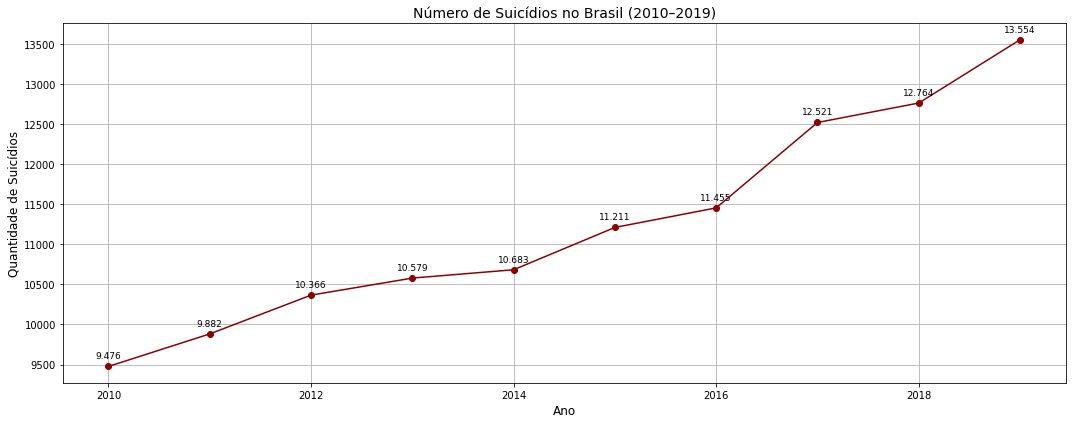

In [0]:
# Dados obtidos na consulta acima
anos = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
suicidios = [9476, 9882, 10366, 10579, 10683, 11211, 11455, 12521, 12764, 13554]

# Criando o gráfico
plt.figure(figsize=(15, 6))
plt.plot(anos, suicidios, marker='o', linestyle='-', color='darkred')

plt.title('Número de Suicídios no Brasil (2010–2019)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Suicídios', fontsize=12)
plt.grid(True)

# Adicionando valores nos pontos
for ano, qtd in zip(anos, suicidios):
    plt.text(ano, qtd + 100, f'{qtd:,}'.replace(',', '.'), ha='center', fontsize=9) # uso de função para formatação com separador de milhares

plt.tight_layout()
plt.show()


## 2. Para cada ano, qual o estado brasileiro com o maior número de suicídios?

In [0]:
%sql
-- uso do WITH para tornar o código mais legível e fácil de realizar manutenções
-- além disso, tais tabelas temporárias podem ser referenciadas sempre que necessárias (promovendo/facilitando a reutilização de código)
WITH suicidios_por_uf_ano AS (
  SELECT
    year(DTOBITO) as ano,
    estado,
    COUNT(1) AS total_suicidios
  FROM
    suicidios_br_gold.ocorrencias_suicidios
  GROUP BY
    ano, estado
),
rank_estados AS (
  SELECT
    ano,
    estado,
    total_suicidios,
    ROW_NUMBER() OVER (PARTITION BY ano ORDER BY total_suicidios DESC) AS rank_uf
  FROM
    suicidios_por_uf_ano
)

SELECT
  ano,
  estado,
  total_suicidios
FROM
  rank_estados
WHERE
  rank_uf = 1
ORDER BY
  ano;

ano,estado,total_suicidios
2010,SP,1969
2011,SP,2050
2012,SP,2100
2013,SP,2211
2014,SP,2237
2015,SP,2302
2016,SP,2200
2017,SP,2306
2018,SP,2211
2019,SP,2384


**Análise da pergunta: Para cada ano, qual estado brasileiro com maior número de suicídios**

**São Paulo** foi o estado com a maior quantidade de suicídios em todos os 10 anos considerados para a análise. 

Trata-se também de um caso curioso porque, ao longo do tempo, a maior concentração de casos se manteve em um único estado brasileiro.

##3. Para cada estado brasileiro, quais os municípios que concentraram a maior parte dos indivíduos que cometeram suicídio (seus municípios de residência)?

In [0]:
%sql

WITH suicidios_por_uf_munic AS (
  SELECT
    estado,
    codmunres,
    COUNT(1) AS total_suicidios
  FROM
    suicidios_br_gold.ocorrencias_suicidios
  GROUP BY
    estado, codmunres
),
rank_municipios AS (
  SELECT
    estado,
    codmunres,
    total_suicidios,
    ROW_NUMBER() OVER (PARTITION BY estado ORDER BY total_suicidios DESC) AS rank_munic
  FROM
    suicidios_por_uf_munic
)

SELECT
  estado,
  codmunres,
  total_suicidios
FROM
  rank_municipios
WHERE
  rank_munic = 1
ORDER BY
  estado;


estado,codmunres,total_suicidios
AC,Rio Branco,231
AL,Maceió,317
AM,Manaus,1005
AP,Macapá,279
BA,Salvador,683
CE,Fortaleza,1374
DF,Brasília,1490
ES,Serra,198
GO,Goiânia,886
MA,São Luís,374


**Análise da pergunta: Para cada estado brasileiro, indique os municípios que concentram a maior parte dos indivíduos que cometeram suicídio**

Para praticamente todos os estados brasileiros, a **maior quantidade de suicídios é cometida por indivíduos que residem nas capitais**. Houveram apenas 2 exceções: Espírito Santo e Santa Catarina.

Uma possível causa para estes suicídios pode estar relacionada a vida mais agitada (maior carga de stress) nos grandes centros urbanos. Porém, analisando somente estes dados de forma isolada não é possível afirmar que esta seja, de fato, uma das causas do suicídio.

## 4. Quem mais cometeu suicídios: homens ou mulheres?

In [0]:
%sql

SELECT COUNT(1), year(DTOBITO) as ano, SEXO
FROM suicidios_br_gold.ocorrencias_suicidios
WHERE SEXO != 'NA'
GROUP BY ano, sexo
ORDER BY ano, count(1) desc

count(1),ano,SEXO
7392,2010,Masculino
2084,2010,Feminino
7780,2011,Masculino
2101,2011,Feminino
8090,2012,Masculino
2273,2012,Feminino
8343,2013,Masculino
2235,2013,Feminino
8438,2014,Masculino
2244,2014,Feminino


**Análise da pergunta: Dentre 2010 e 2019, quem mais cometeu suicídio: homens ou mulheres?**

**Indivíduos do sexo masculino** são os que mais cometeram suicídio ao longo destes 10 anos. 

E podemos perceber que a diferença entre os quantitativos anuais é bem expressiva! 

De 2010 a 2011, o número de homens que cometeram suicídio chega a 3 vezes mais em comparação a mulheres. A partir de 2012 aumenta para 4 vezes mais e chegando a 5 vezes mais aproximadamente em 2018 e 2019.

A seguir é apresentado um gráfico de barras ilustrando este cenário.



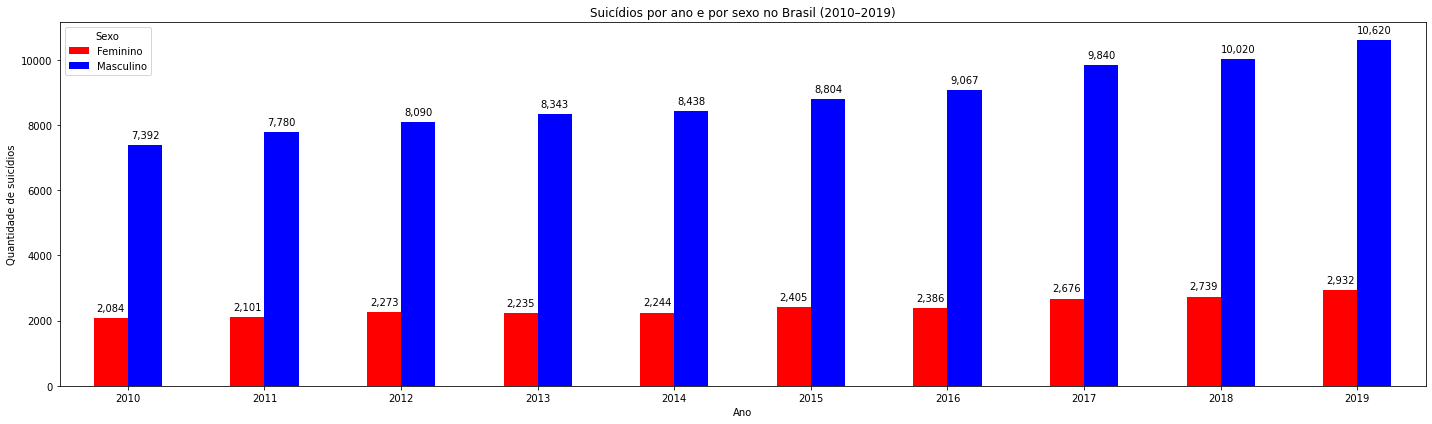

In [0]:
# Dados extraídos da consulta acima
suicidios_por_ano_sexo = [
    [7392, 2010, 'Masculino'],
    [2084, 2010, 'Feminino'],
    [7780, 2011, 'Masculino'],
    [2101, 2011, 'Feminino'],
    [8090, 2012, 'Masculino'],
    [2273, 2012, 'Feminino'],
    [8343, 2013, 'Masculino'],
    [2235, 2013, 'Feminino'],
    [8438, 2014, 'Masculino'],
    [2244, 2014, 'Feminino'],
    [8804, 2015, 'Masculino'],
    [2405, 2015, 'Feminino'],
    [2386, 2016, 'Feminino'],
    [9067, 2016, 'Masculino'],
    [9840, 2017, 'Masculino'],
    [2676, 2017, 'Feminino'],
    [2739, 2018, 'Feminino'],
    [10020, 2018, 'Masculino'],
    [2932, 2019, 'Feminino'],
    [10620, 2019, 'Masculino']
]

# Criação do DataFrame
df_suicidios_por_ano_sexo = pd.DataFrame(suicidios_por_ano_sexo, columns=['quantidade', 'ano', 'sexo'])

# Agrupar os dados por ano e sexo
df_group_by_ano_sexo = df_suicidios_por_ano_sexo.groupby(['ano', 'sexo'])['quantidade'].sum().unstack().fillna(0)

# Plotar gráfico de barras agrupadas
ax = df_group_by_ano_sexo.plot(kind='bar', figsize=(20, 6), color=['#ff0000', '#0000ff'])

# Título e rótulos
plt.title('Suicídios por ano e por sexo no Brasil (2010–2019)')
plt.xlabel('Ano')
plt.ylabel('Quantidade de suicídios')
plt.xticks(rotation=0)
plt.legend(title='Sexo')

# Adicionar os valores quantitativos nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                xytext=(0, 10), 
                textcoords='offset points', 
                ha='center', va='center', fontsize=10)

plt.tight_layout()

# Mostrar gráfico
plt.show()


## 5. Qual a taxa de suicídios entre as pessoas com diferentes níveis de escolaridade?

In [0]:
%sql
SELECT 
      ROUND((COUNT(CASE WHEN esc = 'Nenhuma' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_nenhuma,
      ROUND((COUNT(CASE WHEN esc = 'NA' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_nao_informado,
      ROUND((COUNT(CASE WHEN esc = '1 a 3 anos' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_1_a_3_anos,
      ROUND((COUNT(CASE WHEN esc = '4 a 7 anos' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_4_a_7_anos,
      ROUND((COUNT(CASE WHEN esc = '8 a 11 anos' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_8_a_11_anos,
      ROUND((COUNT(CASE WHEN esc = '12 e mais' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_12_e_mais_anos,
      COUNT(*) AS total_linhas
FROM suicidios_br_gold.ocorrencias_suicidios

percent_nenhuma,percent_nao_informado,percent_1_a_3_anos,percent_4_a_7_anos,percent_8_a_11_anos,percent_12_e_mais_anos,total_linhas
4.62,25.04,14.22,24.25,23.07,8.81,112491


**Análise da pergunta: Taxa de suicídio entre os diferentes níveis de escolaridade**

A maior parte dos indivíduos que cometeram suicídio possuem **escolaridade desconhecida**. 

Em segundo e terceiro lugar, encontramos os perfis de escolaridade de '4 a 7 anos' e '8 a 11 anos', respectivamente.

Não foi possível observar nenhum tipo de padrão ou tendência relacionada a escolaridade dos indivíduos que cometeram suicídio. Seriam necessárias outras informações complementares para auxiliar na análise.

A seguir é apresentado um gráfico de pizza para ilustrar este cenário.



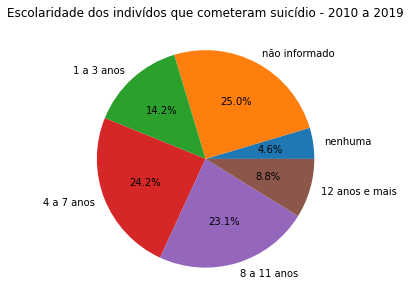

In [0]:
# Dados obtidos na consulta acima
valores_percentuais = [4.62, 25.04, 14.22, 24.25, 23.07, 8.81]
categorias = ['nenhuma', 'não informado', '1 a 3 anos', '4 a 7 anos', '8 a 11 anos', '12 anos e mais']

# Gráfico de pizza
plt.figure(figsize=(5, 5))
plt.pie(valores_percentuais, labels=categorias, autopct='%1.1f%%')
plt.title('Escolaridade dos indivídos que cometeram suicídio - 2010 a 2019')

plt.show()

## 6. Quais as TOP 5 ocupações das pessoas que cometeram suicídio?

In [0]:
%sql
SELECT COUNT(1), ocup
FROM suicidios_br_gold.ocorrencias_suicidios
WHERE ocup != 'NA'
GROUP BY ocup
ORDER BY count(1) desc
LIMIT 5

count(1),ocup
7836,APOSENTADO/PENSIONISTA
7756,ESTUDANTE
6149,DONA DE CASA
5924,TRABALHADOR AGROPECUARIO EM GERAL
2520,EMPREGADO DOMESTICO NOS SERVICOS GERAIS


**Análise da pergunta: Top 5 ocupações das pessoas que cometeram suicídio - 2010 a 2019**

A maior parte dos indivíduos que cometeram suicídio são **aposentados ou pensionistas**. 

Em seguida, observa-se que os **estudantes** foram os que mais cometeram suicídio neste período. 

De maneira isolada não é possível definir o que levou estas pessoas a se suicidarem, mas uma suspeita poderia ser fatores financeiros. Infelizmente tanto os pensionistas/aposentados quanto os estudantes não possuem uma boa renda e a falta de dinheiro pode, infelizmente, impactar psicologicamente uma pessoa.

## 7. Quais as idades mínima e máxima das pessoas que cometeram suicídio?

In [0]:
%sql
WITH idades_registros_suicidios AS (
  SELECT
    FLOOR(DATEDIFF(CURRENT_DATE, DTNASC) / 365) AS idade
  FROM
    suicidios_br_gold.ocorrencias_suicidios
  WHERE
    DTNASC <> 'NA'
)

SELECT MIN(idade), MAX(idade)
FROM idades_registros_suicidios;

min(idade),max(idade)
5,122


In [0]:
%sql
WITH idades_registros_suicidios AS (
  SELECT
    FLOOR(DATEDIFF(CURRENT_DATE, DTNASC) / 365) AS idade
  FROM
    suicidios_br_gold.ocorrencias_suicidios
  WHERE
    DTNASC <> 'NA'
)

SELECT 
      COUNT(1), idade
FROM 
      idades_registros_suicidios
GROUP BY 
      idade
order by 
      count(1) desc
limit 10;

count(1),idade
2675,43
2523,42
2466,38
2452,39
2427,46
2425,41
2417,40
2392,36
2386,37
2368,47


**Análise da pergunta: Idades mínima e máxima dos indivíduos que cometeram suicídio**

Pelas 2 consultas realizadas acima, vemos que as **idades mínima e máxima** das pessoas que cometeram suicídio variam entre **5 e 122 anos de idade**. Acredito que tenha havido um erro de digitação no momento do cadastro destes dados.

Mas outra informação importante que podemos tirar daqui é que, de acordo com o **TOP10**, temos que pessoas entre **36 e 47 anos** são as que mais cometeram suicídio ao longo destes 10 anos.


## 8. Qual a raça/cor das pessoas que mais cometeram suicídio?

In [0]:
%sql
SELECT 
      COUNT(1), RACACOR
FROM 
      suicidios_br_gold.ocorrencias_suicidios
GROUP BY 
      RACACOR
ORDER BY 
      count(1) desc

count(1),RACACOR
56075,Branca
45695,Parda
5929,Preta
3171,NA
1187,Indígena
434,Amarela


In [0]:
%sql
SELECT 
      ROUND((COUNT(CASE WHEN RACACOR = 'Amarela' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_amarela,
      ROUND((COUNT(CASE WHEN RACACOR = 'Branca' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_branca,
      ROUND((COUNT(CASE WHEN RACACOR = 'Indígena' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_indigena,
      ROUND((COUNT(CASE WHEN RACACOR = 'NA' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_na,
      ROUND((COUNT(CASE WHEN RACACOR = 'Parda' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_parda,
      ROUND((COUNT(CASE WHEN RACACOR = 'Preta' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_preta,
      COUNT(*) AS total_linhas
FROM 
      suicidios_br_gold.ocorrencias_suicidios

percent_amarela,percent_branca,percent_indigena,percent_na,percent_parda,percent_preta,total_linhas
0.39,49.85,1.06,2.82,40.62,5.27,112491


**Análise da pergunta: Raça/cor das pessoas que mais cometeram suicídio**

Há uma predominância de suicídios entre pessoas **brancas** e **pardas**. Juntos somam aproximadamente 89% dos casos, sendo que somente as pessoas brancas já correspondem a praticamente 50% do total de casos.

É possível observar também, que há uma baixa proporção de suicídios entre pessoas pretas, indígenas e amarelas.

A seguir é apresentado um gráfico de pizza para ilustrar este cenário.

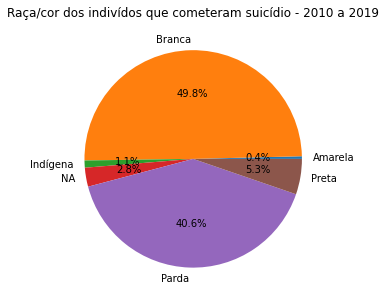

In [0]:
# Dados obtidos na consulta acima
valores_percentuais = [0.39, 49.85,	1.06, 2.82,	40.62, 5.27]
categorias = ['Amarela', 'Branca', 'Indígena', 'NA', 'Parda', 'Preta']

# Gráfico de pizza
plt.figure(figsize=(5, 5))
plt.pie(valores_percentuais, labels=categorias, autopct='%1.1f%%')
plt.title('Raça/cor dos indivídos que cometeram suicídio - 2010 a 2019')

plt.show()

## 9. Quais os locais onde mais se cometeram suicídios?

In [0]:
%sql
SELECT 
      COUNT(1), LOCOCOR
FROM 
      suicidios_br_gold.ocorrencias_suicidios
GROUP BY 
      LOCOCOR
ORDER BY 
      count(1) desc

count(1),LOCOCOR
68221,Domicílio
17579,Hospital
17502,Outros
6996,Via pública
1733,Outro estabelecimento de saúde
460,NA


In [0]:
%sql
SELECT 
      ROUND((COUNT(CASE WHEN LOCOCOR = 'Domicílio' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_domicilio,
      ROUND((COUNT(CASE WHEN LOCOCOR = 'Hospital' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_hospital,
      ROUND((COUNT(CASE WHEN LOCOCOR = 'NA' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_na,
      ROUND((COUNT(CASE WHEN LOCOCOR = 'Outro estabelecimento de saúde' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_outro_estab_saude,
      ROUND((COUNT(CASE WHEN LOCOCOR = 'Outros' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_outros,
      ROUND((COUNT(CASE WHEN LOCOCOR = 'Via pública' THEN 1 END) / COUNT(*)) * 100, 2) AS percent_via_publica,
      COUNT(*) AS total_linhas
FROM 
      suicidios_br_gold.ocorrencias_suicidios

percent_domicilio,percent_hospital,percent_na,percent_outro_estab_saude,percent_outros,percent_via_publica,total_linhas
60.65,15.63,0.41,1.54,15.56,6.22,112491


**Análise da pergunta: Locais onde mais se cometeram suicídios**

Pode-se observar que 60% do total de suicídios ocorream no **domicílio**.

Trata-se de um cenário muito crítico, visto que é mais difícil prever a ocorrência de um suicídio dentro dos domicílios. Além disso, não temos dados suficientes para saber se estas pessoas vivem sozinhas e, em caso positivo, torna-se um problema ainda mais desafiador.

## 10. Qual o período do ano em que as pessoas mais cometeram suicídio? É um comportamento que se repete em todos os anos?

In [0]:
%sql
SELECT COUNT(1), year(DTOBITO) as ano, month(DTOBITO) as mes
FROM suicidios_br_gold.ocorrencias_suicidios
GROUP BY ano, mes
ORDER BY ano, mes

count(1),ano,mes
851,2010,1
726,2010,2
803,2010,3
757,2010,4
810,2010,5
702,2010,6
747,2010,7
791,2010,8
772,2010,9
860,2010,10


![](https://github.com/andressapedrosa/data_engineering/blob/main/grafico_distribuicao_anos_meses.jpg?raw=true)

**Análise da pergunta: Período do ano em que as pessoas mais cometem suicídio**

Pode-se observar que ao longo dos anos há um **aparente padrão**: **picos de suicídio** ocorreram nos meses de **Março, Maio e Outubro**. Além disso, há uma tendência de aumento no fim do ano (Dezembro).

Já os meses de **Fevereiro, Junho e Novembro** apresentam **queda** no número de suicídios.

Tais dados analisados de forma isolada infelizmente não são suficientes para entender as possíveis causas desse padrão. São necessários mais dados relacionados a cada um dos respectivos períodos.

## 11. Quais são as TOP 5 causas mais frequentes de suicídios?

In [0]:
%sql
SELECT 
      COUNT(1), DESCRICAO
FROM 
      suicidios_br_gold.ocorrencias_suicidios
GROUP BY 
      DESCRICAO
ORDER BY 
      count(1) desc
LIMIT 5

count(1),DESCRICAO
53399,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - residência"
11877,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - local não especificado"
3599,Lesão autoprovocada intencionalmente por disparo de outra arma de fogo e de arma de fogo não especificada - residência
3425,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - outros locais especificados"
2609,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - rua e estrada"


**Análise da pergunta: TOP 5 causas mais frequentes de suicídios**

Pode-se observar que 47% do total de suicídios cometidos entre 2010 e 2019 foram provocados por **enforcamento, estrangulamento e sufocação na própria residência**.

Trata-se de um cenário muito crítico, visto que a privacidade do ambiente doméstico dificulta a prevenção e intervenção. Além disso, não temos dados suficientes para saber se estas pessoas viviam sozinhas e, em caso positivo, torna-se um problema ainda mais desafiador.


## 12. Para cada ano, quais as TOP 3 causas mais frequentes de suicídios? Há um padrão de comportamento ao longo dos anos?

In [0]:
%sql
WITH causas_suicidios_por_ano AS (
  SELECT
    COUNT(1) as quantidade, year(DTOBITO) as ano, DESCRICAO
  FROM
    suicidios_br_gold.ocorrencias_suicidios
  GROUP BY
    ano, DESCRICAO
),
top_3_cids_ano AS (
  SELECT
    quantidade,
    ano,
    DESCRICAO,
    ROW_NUMBER() OVER (PARTITION BY ano ORDER BY quantidade DESC) AS rank_cid
  FROM
    causas_suicidios_por_ano
)

SELECT 
      quantidade, ano, DESCRICAO
FROM 
      top_3_cids_ano
where 
      rank_cid <= 3
ORDER BY 
      ano

quantidade,ano,DESCRICAO
3892,2010,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - residência"
1066,2010,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - local não especificado"
354,2010,"Auto-intoxicação por e exposição, intencional, a pesticidas - local não especificado"
4056,2011,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - residência"
1279,2011,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - local não especificado"
366,2011,"Auto-intoxicação por e exposição, intencional, a pesticidas - local não especificado"
4460,2012,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - residência"
1342,2012,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - local não especificado"
347,2012,Lesão autoprovocada intencionalmente por disparo de outra arma de fogo e de arma de fogo não especificada - residência
4695,2013,"Lesão autoprovocada intencionalmente por enforcamento, estrangulamento e sufocação - residência"


**Análise da pergunta: Para cada ano, quais as TOP 3 causas mais frequentes de suicídios?**

Conforme visto anteriormente, os 3 CIDs indicados abaixo são as maiores causas de suicídios:
- Lesão autoprovocada intencionalmente por **enforcamento, estrangulamento e sufocação - residência**
- Lesão autoprovocada intencionalmente por **enforcamento, estrangulamento e sufocação - local não especificado**
- Lesão autoprovocada intencionalmente por **disparo de outra arma de fogo e de arma de fogo não especificada - residência**

De acordo com a tabela anterior, percebemos os seguintes padrões:

- **Anos que seguem um determinado padrão**:
  - **2012, 2013, 2014, 2016, 2017, 2018**
    - Apresentam enforcamento como 1ª e 2ª causas em residência e local não especificado.

- **Anos que fugiram do padrão**:
  - **2010, 2011**
    - Uso de pesticidas como 3ª causa
  - **2015**
    - Arma de fogo como 3ª causa
  - **2019**
    - Local “outros locais especificados” como 3ª causa


# Autoavaliação

Este trabalho foi bem desafiador e, ao mesmo tempo, bastante enriquecedor em termos de conhecimento, tanto a nível técnico quanto de negócio também.
Sou da área de tecnologia, presto serviço para o setor de Saúde e foi muito interessante aprofundar meus conhecimentos nesta área de negócio também.

Consegui atingir os objetivos traçados no início deste projeto, mas tive dificuldade em encontrar outros datasets para compor meu modelo de dados. Sei que este trabalho ainda tem muito a evoluir! Infelizmente os resultados das análises feitas não são conclusivos para entender o que de fato causou o alto número de suicídios e que só aumentou ao longo dos anos.

Informações extras que eu entendo que ajudariam na análise:
- faixa salarial dos indivíduos
- indicativo se está empregado ou desempregado
- número de pessoas com quem vive (para identificar se a pessoa mora ou não sozinha)
- indicativo de depressão (se possui ou não)

Para projetos futuros, penso na evolução deste trabalho enriquecendo o modelo com mais informações relevantes, como estas listadas acima. Da mesma maneira, vejo a possibilidade de ajustar esse trabalho para criar um modelo de dados em esquema estrela:
- tabela FATO_OCORRENCIAS_SUICIDIOS
- tabela DIM_TEMPO
- tabela DIM_UF (para os estados brasileiros)
- tabela DIM_SEXO
- tabela DIM_RACACOR